In [3]:
import cv2
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import os
from skimage.feature import greycomatrix, greycoprops
from skimage import data

In [6]:
train_path="D:\\train_test"
# get the training labels
import os

train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(np.array(train_labels).shape)


(3,)


In [7]:
# empty lists to hold feature vectors and labels
global_features = []
labels = []
i, j = 0, 0
k = 0
for training_name in train_labels:
        # join the training data path and each species training folder
    img_list = os.listdir(train_path + '/' + training_name)
    print('TRAINING_NAME',training_name)
    current_label = training_name
    print('current_label',current_label)
    k = 1
    for img in img_list:
            image=train_path + '/' + training_name+'/' + img
            ip_img = cv2.imread(image,cv2.IMREAD_UNCHANGED)
            plt.figure(figsize=(10, 10))
            b,g,r = cv2.split(ip_img)       # get b,g,r
            ip_img = cv2.merge([r,g,b])     # switch it to rgb
            plt.subplots_adjust(bottom=1.0, right=1.8, top=3.0, wspace = 0.5, hspace=0.5)
#             plt.subplot(661),plt.imshow(ip_img),plt.title('ORIGINAL')
            fixed_size=(256,256)
            image = cv2.resize(ip_img, fixed_size)
#             plt.subplot(662),plt.imshow(image),plt.title('Resized Image')
            ###HISTOGRAM EQUALIZATION####
            img_out = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            img_out[:,:,0]=cv2.equalizeHist(img_out[:,:,0])
            img_equi=cv2.cvtColor(img_out, cv2.COLOR_YUV2BGR)
#             plt.subplot(663),plt.imshow(img_equi),plt.title('EQUILIZED IMAGE')
          ####RGB TO LAB COLOR SPACE CONVERSION###
            plt.figure(figsize=(20, 20))    
            lab_image = cv2.cvtColor(img_equi, cv2.COLOR_BGR2LAB)
#             plt.subplot(664),plt.imshow(lab_image),plt.title('LAB_IMAGE')

            ###Splitting LAB Color Model####
#             plt.figure(figsize=(20, 20))    
            l_channel,a_channel,b_channel = cv2.split(lab_image)        
#             plt.subplot(665),plt.imshow(l_channel),plt.title('L Channel Image')
#             plt.subplot(666),plt.imshow(a_channel),plt.title('A Channel Image')
#             plt.subplot(667),plt.imshow(b_channel),plt.title('B Channel Image')
            ####k means clustering of B channel######
            vectorized=b_channel.reshape(-1,1)
            vectorized=np.float32(vectorized)
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10, 1.0)
            k=3
            res1,label,center=cv2.kmeans(vectorized,k,None,
            criteria,10,cv2.KMEANS_RANDOM_CENTERS)
            center=np.uint8(center)
            c=(label.flatten())
            res2 = center[c.astype(int)]
            res3= res2.reshape((a_channel.shape))
            # c=(label==0).flatten()
            reshape_label=label.reshape(fixed_size)
#             plt.subplot(668),plt.imshow(reshape_label,cmap='gray')
#             plt.subplot(669),plt.imshow(res3)
            ####Finding Infected Cluster###########3
            num1=center[0]
            num2=center[1]
            num3=center[2]
            if (num1 < num2) and (num1 < num3):
                smallest_num = num1
            elif (num2 < num1) and (num2 < num3):
                smallest_num = num2
            else:
                smallest_num = num3
#             print("The smallest of the 3 numbers is : ", smallest_num)

            cluster1=np.zeros(lab_image.shape,np.uint8)
            cluster2=np.zeros(lab_image.shape,np.uint8)
            cluster3=np.zeros(lab_image.shape,np.uint8)
            cluster4=np.zeros(lab_image.shape,np.uint8)
            for x in range(255):
                    for y in range(255):
                        if np.all((res3[x,y])==center[0]):
                            cluster1[x,y]=ip_img[x,y]
                            if smallest_num==center[0]:
                                infected_cluster=cluster1
                        elif np.all((res3[x,y])==center[1]):
                            cluster2[x,y]=ip_img[x,y]
                            if smallest_num==center[1]:
                                infected_cluster=cluster2
                        elif np.all((res3[x,y])==center[2]):
                            cluster3[x,y]=ip_img[x,y]   
                            if smallest_num==center[2]:
                                infected_cluster=cluster3
    #                     elif np.all((res3[x,y])==center[3]):
    #                         cluster4[x,y]=ip_img[x,y]

            plt.figure(figsize=(16, 16))
#             plt.subplot(141),plt.imshow(cluster1),plt.title('cluster1')
#             plt.subplot(142),plt.imshow(cluster2),plt.title('cluster2')
#             plt.subplot(143),plt.imshow(cluster3),plt.title('cluster3')
#             plt.subplot(144),plt.imshow(infected_cluster),plt.title('infected cluster')

        
            img_out = cv2.cvtColor(infected_cluster, cv2.COLOR_RGB2GRAY)
#             plt.subplot(144),plt.imshow(img_out, cmap='gray'),plt.title('Gray_infected_image')
            ##########Statistical Feature Extraction#######
#             mean_g=np.mean(infected_cluster)
#             std_g=np.std(infected_cluster)
            
            ##########Textual_features_extrcation##########
            g = greycomatrix(img_out, [2], [0], levels=256,normed=True, symmetric=True)
    #         plt.subplot(667),plt.imshow(g, cmap='gray')
            contrast_g=greycoprops(g,'contrast')
            correlation_g=greycoprops(g,'correlation')
            energy_g=greycoprops(g,'energy')
                    # entropy_g=greycoprops(g,'entropy')
            homogeneity_g=greycoprops(g,'homogeneity')
            dissimilarity_g=greycoprops(g,'dissimilarity')
            global_feature = np.hstack(([contrast_g,correlation_g,energy_g,homogeneity_g,dissimilarity_g]))
#             print('global_feature is',global_feature)
            labels.append(current_label)
            global_features.append(global_feature)

            i += 1
            k += 1
    #         print('k is',k)
    #         print('i is',i)
    print( "[STATUS] processed folder: {}".format(current_label))
    print('GLOBAL FEATURE SHAPE',np.array(global_features).shape)

    j += 1
#         print('j is',j)
    # get the overall training label size
print ("[STATUS] training Labels {}".format(np.array(labels).shape))
# cv2.imshow('L PART',l_channel)
# cv2.imshow('A PART',a_channel)
# # cv2.imshow('B PART',b_channel)
# # Print the minimum and maximum of lightness.
# print (np.min(l_channel)) # 0
# print (np.max(l_channel))  # 255

# # Print the minimum and maximum of a.
# print (np.min(a_channel))  # 42
# print (np.max(a_channel))  # 226

# # Print the minimum and maximum of b.
# print (np.min(b_channel))  # 20
# print (np.max(b_channel))  # 223
# cv2.imshow('EQUALIZED RGB IMAGE',img_equi)
# cv2.imshow('Input Image',ip_img)
# img_out=cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
# plt.imshow(img_out)

TRAINING_NAME Tomato_Early_blight
current_label Tomato_Early_blight


C:\Users\moham\Anaconda3\lib\site-packages\skimage\feature\texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):
C:\Users\moham\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[STATUS] processed folder: Tomato_Early_blight
GLOBAL FEATURE SHAPE (528, 1, 5)
TRAINING_NAME Tomato_Healthy
current_label Tomato_Healthy
[STATUS] processed folder: Tomato_Healthy
GLOBAL FEATURE SHAPE (908, 1, 5)
TRAINING_NAME Tomato___Late_blight
current_label Tomato___Late_blight
[STATUS] processed folder: Tomato___Late_blight
GLOBAL FEATURE SHAPE (1260, 1, 5)
[STATUS] training Labels (1260,)
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001D151A828C8> (for post_execute):


MemoryError: In RendererAgg: Out of memory

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

In [8]:

global_features=np.array(global_features).reshape(-1,5)
print ("[STATUS] completed Global Feature Extraction...")
# get the overall feature vector size
print ("[STATUS] feature vector size {}".format(np.array(global_features).shape))



# get the overall training label size
print ("[STATUS] training Labels {}".format(np.array(labels).shape))
# encode the target labels
targetNames = np.unique(labels)
print(targetNames)

[STATUS] completed Global Feature Extraction...
[STATUS] feature vector size (1260, 5)
[STATUS] training Labels (1260,)
['Tomato_Early_blight' 'Tomato_Healthy' 'Tomato___Late_blight']


In [9]:
# organize imports
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# # encode the target labels
# targetNames = np.unique(labels)
# print(labels)
le = LabelEncoder()
print('Label',le)
target = le.fit_transform(labels)
print(target)
print ("[STATUS] training labels encoded...",np.array(labels).shape)

Label LabelEncoder()
[0 0 0 ... 2 2 2]
[STATUS] training labels encoded... (1260,)


In [10]:
# organize imports
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)


In [11]:
print ("[STATUS] feature vector normalized...")

print ("[STATUS] target labels: {}".format(target))
print ("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 ... 2 2 2]
[STATUS] target labels shape: (1260,)


In [12]:
# save the feature vector using HDF5
import h5py
h5f_data = h5py.File('d:/output/data.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(global_features))

h5f_label = h5py.File('d:/output/labels.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()
print ("[STATUS] end of training..")

C:\Users\moham\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[STATUS] end of training..


In [13]:
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

In [14]:
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))

# variables to hold the results and names
results = []
names = []
scoring = "accuracy"

# import the feature vector and trained labels
h5f_data = h5py.File('D:/output/data.h5', 'r')
h5f_label = h5py.File('D:/output/labels.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print ("[STATUS] features shape: {}".format(global_features.shape))
print ("[STATUS] labels shape: {}".format(global_labels.shape))

print ("[STATUS] training started...")

[STATUS] features shape: (1260, 5)
[STATUS] labels shape: (1260,)
[STATUS] training started...


In [24]:
# train_test_split size
test_size = 0.10
# seed for reproducing same results
# seed = 9
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=None)

print ("[STATUS] splitted train and test data...")
print ("Train data  : {}".format(trainDataGlobal.shape))
print ("Test data   : {}".format(testDataGlobal.shape))
print ("Train labels: {}".format(trainLabelsGlobal.shape))
print ("Test labels : {}".format(testLabelsGlobal.shape))
print(testLabelsGlobal.size)
print(trainDataGlobal.size)

[STATUS] splitted train and test data...
Train data  : (1134, 5)
Test data   : (126, 5)
Train labels: (1134,)
Test labels : (126,)
126
5670


predictions [1 0 0 0 2 1 2 0 0 0 1 2 0 0 2 0 0 1 0 2 0 0 0 0 0 0 0 0 1 2 2 0 0 0 0 1 0
 2 2 2 1 0 2 0 0 0 2 0 0 1 0 0 2 0 1 0 0 2 0 2 0 1 1 0 2 1 1 1 0 0 1 0 2 0
 0 0 0 0 0 0 1 0 2 0 0 0 0 0 2 2 1 0 1 1 0 0 0 2 2 1 1 1 2 0 0 1 1 1 0 1 2
 0 1 1 2 2 0 1 0 0 0 0 2 1 0 1]
             precision    recall  f1-score   support

          0       0.78      0.82      0.80        65
          1       0.94      0.91      0.92        32
          2       0.59      0.55      0.57        29

avg / total       0.78      0.78      0.78       126

TEST LABELS [1 0 0 0 2 1 2 0 0 0 1 0 1 0 0 0 0 1 0 2 0 0 0 0 2 0 0 2 1 0 0 2 0 0 0 1 0
 2 2 2 1 2 2 0 0 2 2 0 0 1 0 0 2 1 1 0 0 0 2 2 0 1 1 2 2 1 1 1 0 0 1 0 0 0
 2 0 2 0 0 2 0 0 0 0 0 0 0 0 0 2 2 2 1 1 0 0 0 2 0 1 1 1 2 0 0 1 1 1 0 1 2
 0 1 1 2 0 2 1 1 0 0 0 0 1 0 1]
Score 0.7777777777777778


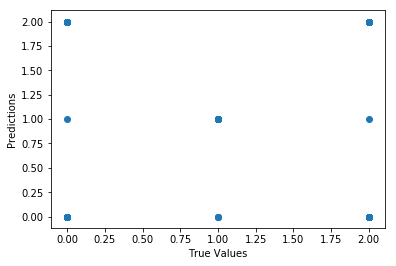

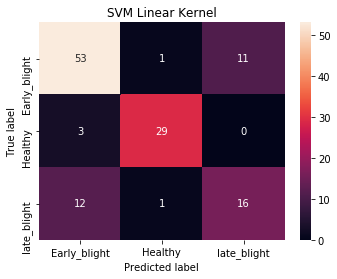

In [26]:
import pandas as pd
import seaborn as sns
clf = RandomForestClassifier(n_estimators=100, random_state=9)

# anova_svm = make_pipeline(anova_filter, clf)
model=clf.fit(trainDataGlobal, trainLabelsGlobal)
y_pred = model.predict(testDataGlobal)
print("predictions",y_pred)
print(classification_report(testLabelsGlobal, y_pred))
print("TEST LABELS",testLabelsGlobal)
plt.scatter(testLabelsGlobal, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print ("Score", model.score(testDataGlobal, testLabelsGlobal))
cm=confusion_matrix(testLabelsGlobal,y_pred)
plt.figure(figsize=(5.5,4))
cm_df = pd.DataFrame(cm,
                     index = ['Early_blight','Healthy','late_blight'], 
                     columns = ['Early_blight','Healthy','late_blight'])
sns.heatmap(cm_df, annot=True)
plt.title('SVM Linear Kernel')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

LR: 0.732804 (0.044896)
LDA: 0.749559 (0.022894)
KNN: 0.465608 (0.007788)
CART: 0.679012 (0.013887)
RF: 0.745150 (0.013198)
NB: 0.671958 (0.040005)
SVM: 0.477072 (0.025770)


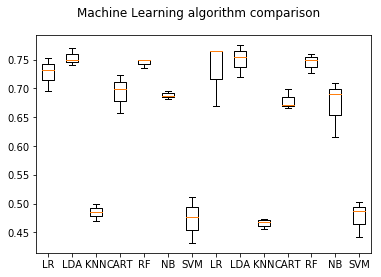

In [25]:
import warnings
warnings.filterwarnings('ignore')

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=3, random_state=7)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [19]:
1.9e+02

190.0

In [ ]:


plt.imshow(component)

In [ ]:
#### Mean of AB Channel#########33

In [ ]:
c=(label==0).flatten()
c.shape

In [ ]:
ip_img[0,0,0:2]

In [ ]:
ip_img[0,0,0]

In [ ]:
ip_img[0,0,1]

In [ ]:
ip_img[0,0,2]

In [ ]:
lab_image[0,0,0]

In [ ]:
lab_image[0,0,1]

In [ ]:
plt.hist(res3.ravel(),127,[0,127]); plt.show()

In [ ]:
centers

In [ ]:

img = cv.medianBlur(img_out,5)


Co-occurance Matrix

In [ ]:
correlation_g

In [ ]:
energy_g

In [ ]:
homogeneity_g

In [ ]:
contrast_g

In [ ]:
m, s = cv2.meanStdDev(res3)

In [ ]:
center[1]

In [ ]:
plt.imshow(res)

In [ ]:
plt.imshow(image-res)

In [ ]:
cv2.imshow('cluster1',component)

In [ ]:
component[150,100]

In [ ]:
res3[100,100]

In [ ]:
res3[100,100]=(200,100,123)

In [ ]:
res3[100,100]

In [ ]:
if (np.all(res3[100,100]==(200,10,123))):
    print('hi')